# Load stuff

In [1]:
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from textblob import TextBlob
from wordcloud import WordCloud, ImageColorGenerator
# nltk.download('punkt')
# nltk.download('words')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [2]:
def lin_reg(x, y):
    A = np.vstack((x, np.ones_like(x))).T
    m, b = np.linalg.lstsq(A, Y, rcond=None)[0]
    
    return m, b

# Load dataset

## BGG ratings

In [3]:
#Kaggle BoardGameGeek dataset
#Download from https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews
# and place in dataset folder

dataBig = pd.read_csv('dataset/bgg-19m-reviews.csv')
print(len(dataBig), "rows")

18964807 rows


In [4]:
#Only ratings with comments
dataValid = dataBig[pd.notna(dataBig['comment'])]
print(len(dataValid), "rows with comments")

3368619 rows with comments


In [5]:
data = dataValid
# data = dataValid.sample(10_000) #Faster for testing

## Coursera reviews (optional)

In [ ]:
#Kaggle Coursera reviews dataset (not needed)
#Download from https://www.kaggle.com/datasets/septa97/100k-courseras-course-reviews-dataset
# and place in dataset folder

data = pd.read_csv('dataset/coursera reviews.csv')
print(len(data), "rows")

In [ ]:
data = pd.DataFrame({
    'comment': data['Review'],
    'rating': data['Label']
})

In [ ]:
#Ratings should be -1 to 1
data['rating'] = data['rating'] / 2 - 1.5

# Dataset Statistics

In [6]:
data

,Unnamed: 0,user,rating,comment,ID,name
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic
5,5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic
8,8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic
...,...,...,...,...,...,...
18964798,18964798,Peter The Rat,4.0,"Sadly, to slow moving and fiddly!",1752,Haps
18964800,18964800,spellengek,4.0,"Weird card game with some nice gameplay, but a...",1752,Haps
18964803,18964803,Gregarius,2.0,"I hated this game. Too complicated to set up, ...",1752,Haps
18964804,18964804,Lajos,2.0,Sold in Geekauction for 3 GG.,1752,Haps


In [7]:
#Avg char count
data['comment'].apply(len).mean()

211.05346196764907

In [8]:
#Avg word count
data['comment'].apply(lambda c: len(c.split())).mean()

37.68614527199425

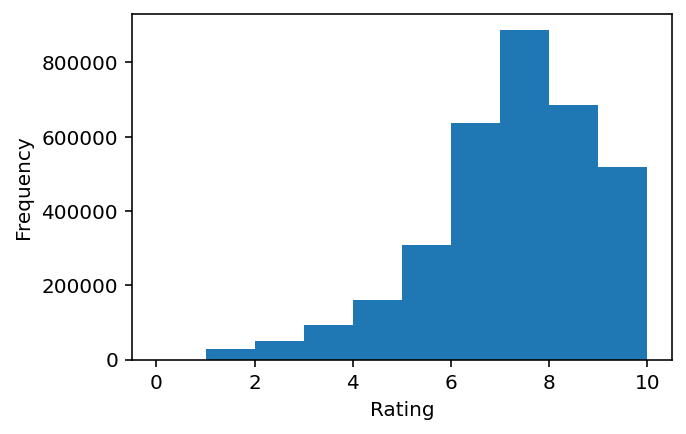

In [9]:
ax = (data['rating']).plot.hist(bins=10, xlabel='rating', figsize=(5, 3))
ax.set_xlabel("Rating");
plt.subplots_adjust(top = 0.95, bottom = 0.15, right = 0.95, left = 0.2)
plt.savefig("figures/rating_hist.pdf")

# Build lexicon from average ratings

In [10]:
#Rescale if needed (not really used much)
data['ratingResale'] = data['rating'] / 5 - 1

/tmp/ipykernel_747542/3455234706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ratingResale'] = data['rating'] / 5 - 1


In [11]:
#Only include english non-stopwords, lemmatize, and lowercase
validWords = set(w.lower() for w in nltk.corpus.words.words())
stopWords = set(w.lower() for w in nltk.corpus.stopwords.words())
validWords -= stopWords
lemmatizer = WordNetLemmatizer()

def toWords(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(w) for w in words]
    words = [w.lower() for w in words]
    return tuple(words)

print(toWords("Hello worlds! I am a person"))

('hello', 'world', '!', 'i', 'am', 'a', 'person')


In [12]:
#Split comment to words
words = []
for i, c in enumerate(data['comment']):
    words.append(toWords(c))
    if i % 5000 == 0:
        print('.', end='')

data['words'] = words

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/tmp/ipykernel_747542/1360956924.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['words'] = words


In [13]:
#Only keep words that appear in 1000 or more comments and are in validWords
wordCounts = {}

for i, (_, row) in enumerate(data.iterrows()):
    for word in set(row["words"]):
        wordCounts[word] = wordCounts.get(word, 0) + 1
    if i % 5000 == 0:
        print('.', end='')

dictionary = {w for w in validWords if wordCounts.get(w, 0) >= 1000}

data["words"] = data['words'].apply(lambda ws: tuple(w for w in ws if w in dictionary))

..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

/tmp/ipykernel_747542/1340035720.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["words"] = data['words'].apply(lambda ws: tuple(w for w in ws if w in dictionary))


In [14]:
data[['rating', 'words']]

,rating,words
1,10.0,"(favorite, game, time, row, pandemic, store, j..."
2,10.0,"(tend, love, easily, tire, game, pandemic, joi..."
4,10.0,"(amazing, game, play, wife, game, imagine, tir..."
5,10.0,"(hey, finally, rate, game, couple, year, pande..."
8,10.0,"(love, great, fun, play, forward)"
...,...,...
18964798,4.0,"(sadly, slow, moving)"
18964800,4.0,"(weird, card, game, nice, problem, game, find,..."
18964803,2.0,"(game, complicated, set, boring, continue)"
18964804,2.0,"(sold,)"


In [15]:
#Compute score as avg rating
wordRatings = {w: [] for w in dictionary}

for i, row in data.iterrows():
    for word in row["words"]:
        wordRatings[word].append(row['rating'])

In [16]:
wordScores = {w: np.mean(r) for w, r in wordRatings.items()}
wordWeights = {w: 1 for w, r in wordRatings.items()}

In [17]:
def predict(words):
    #predict rating by averaging score
    # words = [w for w in words if w in dictionairy]
    if len(words) == 0:
        return np.nan
    words = words[:]
    return np.sum([wordScores[w] * wordWeights[w] for w in words]) / np.sum([wordWeights[w] for w in words])

# Results

In [18]:
#Construct pd dataframe of words (for nice display)
words = pd.DataFrame({"word": wordScores.keys(), "score": wordScores.values(), "weights": wordWeights.values()})
words.sort_values(by='score', inplace=True)
words.reset_index(drop=True, inplace=True)
words.to_csv('words.csv', index=False)
words

,word,score,weights
0,ugh,4.117879,1
1,garbage,4.447380,1
2,unplayable,4.584249,1
3,pointless,4.594815,1
4,boredom,4.637409,1
...,...,...,...
3228,phenomenal,8.319569,1
3229,excelente,8.353379,1
3230,addicted,8.391496,1
3231,masterpiece,8.727073,1


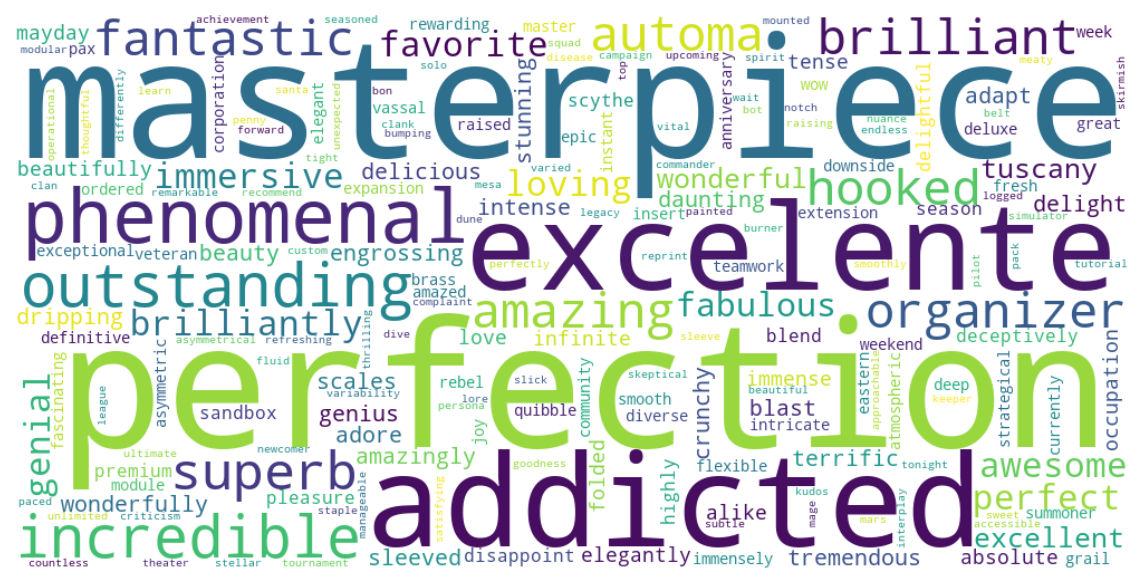

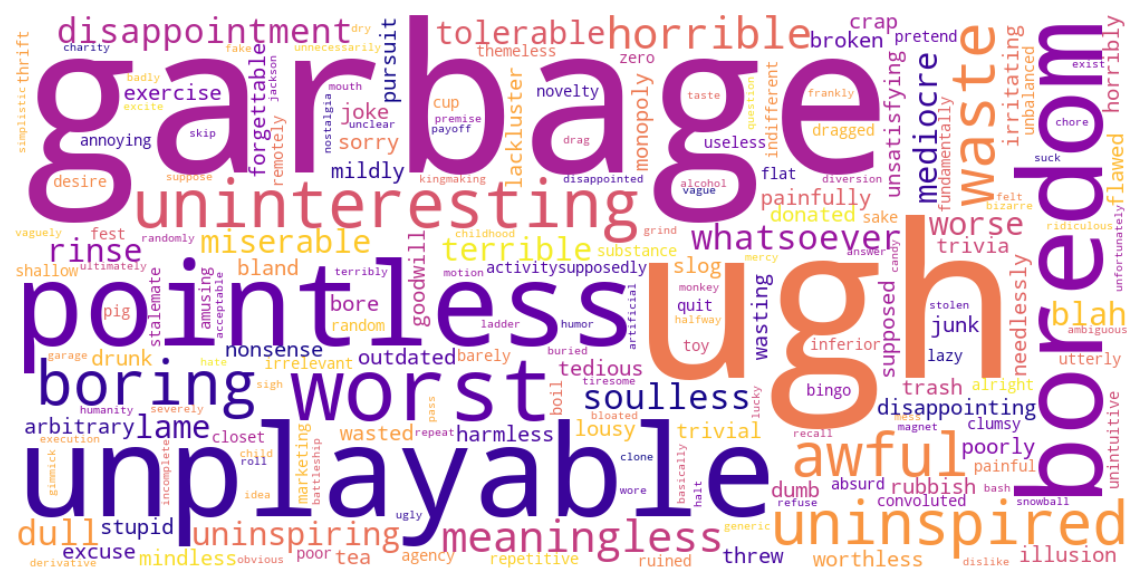

In [19]:
wordcloud = WordCloud(
    width=1000, height=500, background_color="white", colormap="viridis"
).generate_from_frequencies(
    {w: s for w, s in wordScores.items()}
    
)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("figures/wordcloud_pos1.pdf", bbox_inches='tight')
plt.show()

wordcloud = WordCloud(
    width=1000, height=500, background_color="white", colormap="plasma"
).generate_from_frequencies(
    {w: -s for w, s in wordScores.items()}
)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("figures/wordcloud_neg1.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_747542/2615007051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['predRating'] = data['words'].apply(predict)


0.05734502962900074


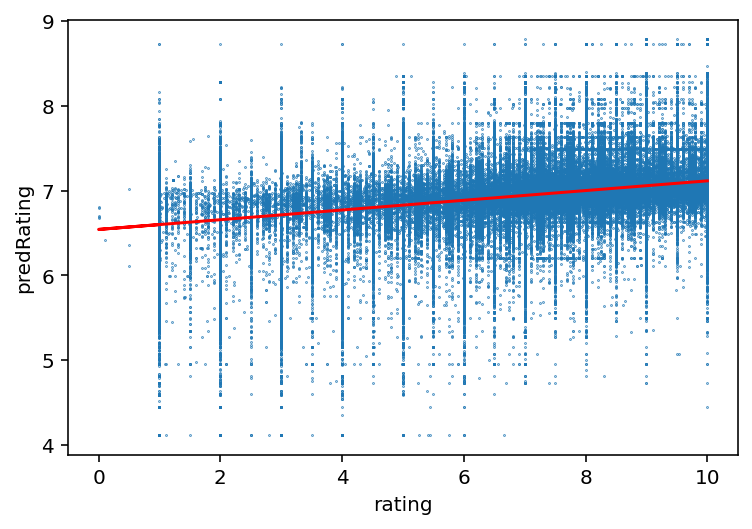

In [20]:
data['predRating'] = data['words'].apply(predict)
valid = ~data['predRating'].isna()
X = data[valid]['rating'].values
Y = data[valid]['predRating'].values

data[valid].plot.scatter(x='rating', y='predRating', s=0.1)
m, b = lin_reg(X, Y)
yPred = m * X + b
plt.plot(X, yPred, color='red')
print(m)

plt.savefig("figures/predRatings_scatter.pdf")

In [21]:
s = [w for w in toWords("This is a masterpiece!") if w in dictionary]
print(s)
predict(s) / 5 - 1

['masterpiece']


0.7454145954904607

# Other experements
You should probably subsample the dataset (e.g. down to 10K-100K reviews) before running these. 

## Gradient descent to optimize scores

In [83]:
lossList = []

#((r1, (w11, w12, ...)), (r2, (w21, w22, ...))) where all w are in dictionairy
#    to make code faster
dataObj = tuple((row['rating'], tuple(w for w in row['words'] if w in dictionary)) for _, row in data.iterrows())
dataObj = tuple((r, ws) for r, ws in dataObj if len(ws))

def err():
    return sum((r - predict(ws))**2 for r, ws in dataObj) / len(dataObj)

print(err())

3.291736178956165


1 3.2815374078568644
2 3.279654332309091
3 3.278058401076651
4 3.27672221204777
5 3.2755977831587133
6 3.2746526303128265
7 3.2738590780890227
8 3.2731941328131424
9 3.272638556971499
10 3.2721762306275934
11 3.2717936232762863
12 3.271479365256057
13 3.271223895716311
14 3.2710191721795234
15 3.2708584299447554
16 3.270735982227952
17 3.270647053825868
18 3.2705876425218317
19 3.2705544035576577
20 3.2705445533639947


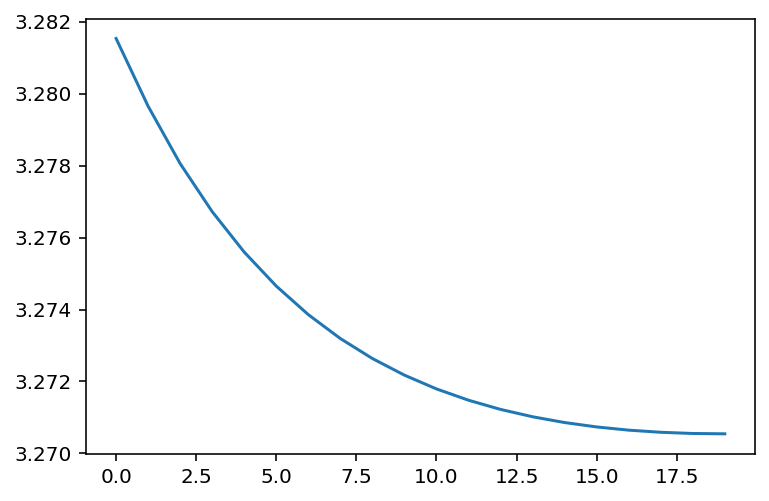

In [84]:
lrS = 2e-4 #Learning rate for sentiment scores
lrW = 3e-5 #Learning rate for weights

for n in range(20):
    scoreGrad = {w: 0 for w in dictionary}
    weightGrad = {w: 0 for w in dictionary}

    for rating, words in dataObj:
        Rhat = predict(words)
        dEdRhat = -2 * (rating - Rhat)
        wSum = sum(wordWeights[w] for w in words)
        for word in words:
            scoreGrad[word] += dEdRhat * wordWeights[word] / wSum
            weightGrad[word] += dEdRhat * (wSum * wordScores[word] - wordWeights[word] * wordScores[word]) / wSum**2

    for w, g in scoreGrad.items():
        wordScores[w] -= lrS * g
        
    for w, g in weightGrad.items():
        wordWeights[w] -= lrW * g
        wordWeights[w] = max(min(wordWeights[w], 3), 0.3)

    loss = err()
    lossList.append(loss)
    print(n + 1, loss)

plt.plot(lossList);

## Using Sentence Transformers (BERT)

In [73]:
stModel = SentenceTransformer('all-MiniLM-L6-v2')

In [74]:
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = stModel.encode(sentences)
embeddings

array([[-0.01371736, -0.04285152, -0.01562859, ...,  0.10017824,
         0.12365721, -0.04229669],
       [ 0.05645248,  0.05500238,  0.03137964, ...,  0.06650875,
         0.08491524, -0.0332849 ],
       [ 0.04393357,  0.05893441,  0.04817837, ...,  0.05216278,
         0.05610648,  0.10206395]], dtype=float32)

In [75]:
emb = stModel.encode(list(data['comment']))
emb.shape

(10000, 384)

In [76]:
A = np.vstack((emb.T, np.ones(emb.shape[0]))).T
Y = data['rating'].values.reshape(-1, 1)
res = np.linalg.lstsq(A, Y, rcond=None)[0]
pred = A @ res

0.32114125844538766


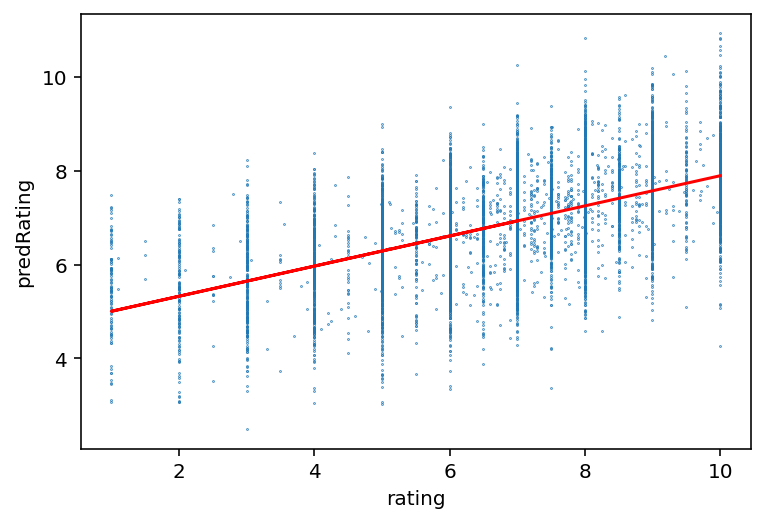

In [77]:
data['predRating'] = pred
X = data['rating'].values
Y = data['predRating'].values

data.plot.scatter(x='rating', y='predRating', s=0.1)
m, b = lin_reg(X, Y)
yPred = m * X + b
plt.plot(X, yPred, color='red')
print(m)

In [78]:
np.mean(np.abs(Y - pred))

1.1400591513774592

In [79]:
testEmb = stModel.encode([
    "The game was very fun!"
])
A = np.vstack((testEmb.T, np.ones(testEmb.shape[0]))).T
float(A @ res)

7.7718148894132995

## Using TextBlob

In [80]:
pred = data['comment'].apply(lambda c: TextBlob(c).sentiment.polarity * 5 + 5) 
pred.mean()
np.mean(np.abs(data['rating'] - pred))

1.971921116328275

0.1397011046411346


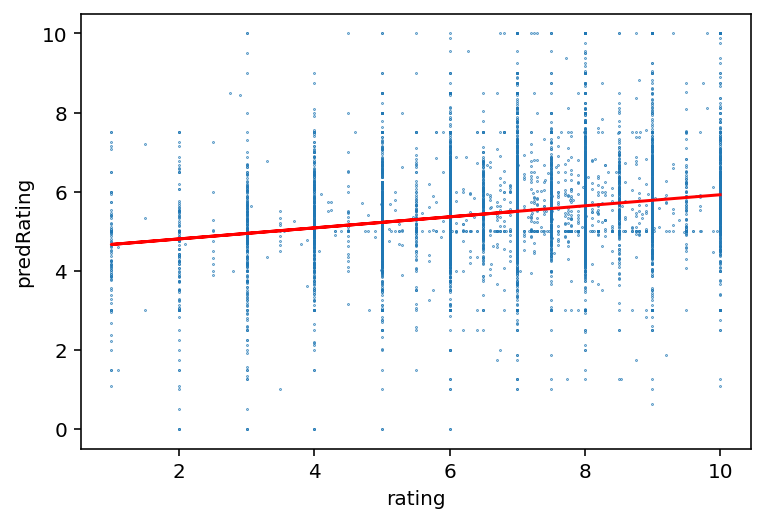

In [81]:
data['predRating'] = pred
X = data['rating'].values
Y = data['predRating'].values

data.plot.scatter(x='rating', y='predRating', s=0.1)
m, b = lin_reg(X, Y)
yPred = m * X + b
plt.plot(X, yPred, color='red')
print(m)

In [82]:
TextBlob("This is the most boring presentation ever!").sentiment

Sentiment(polarity=-0.25, subjectivity=0.75)